In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为自己的Qwen API Key

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-experimental langchain-openai pypdf sentence_transformers chromadb shutil

In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'split_02_embedding_based_semantic_splitter'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [5]:
markdown_document = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()

# 文档切分

In [6]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

device: cuda


/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


库中原始的切分正则表达式是为英文写的，中文无法正常切分

In [7]:
import re

re.split(r"(?<=[.?!])\s+", '太棒了\n    我们继续吧。')

['太棒了\n    我们继续吧。']

In [8]:
re.split(r'[。！？\n\s]+', '太棒了\n    我们继续吧。')

['太棒了', '我们继续吧', '']

langchain_experimental的源码中提到，实现参考自：https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb

In [9]:
import os
import pickle
from langchain_experimental.text_splitter import SemanticChunker

def split_with_embedding(embedding_model, text, breakpoint_threshold_type='percentile', number_of_chunks=None):
    text_splitter = SemanticChunker(
        embedding_model,
        number_of_chunks=number_of_chunks,
        # 此处设置能够切分中文的正则
        sentence_split_regex=r"[。！？\n]+",
        breakpoint_threshold_type=breakpoint_threshold_type,
        # 设置这个参数，避免分片过小
        min_chunk_size=50
    )
    docs = text_splitter.create_documents([text])

    return docs

In [10]:
breakpoint_threshold_types = ["percentile", "standard_deviation", "interquartile", "gradient"]

splitted_docs_dict = {
    f"type_{key}": split_with_embedding(embeddings, markdown_document, key) for key in breakpoint_threshold_types
}

In [11]:
splitted_docs_dict['clustering'] = split_with_embedding(embeddings, markdown_document, 'percentile', 120)

在后面的长度分布中可以看到，切分到的块普遍比较大，原始实现，作者在最后提到，可以对较大的块进行递归切分，此处我们只选一种类型，对它较大的块进行二次切分，并比较二次切分是
否有效

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=50,
    separators=['\n\n', '\n', '\s', '，']
)

def further_split(docs, max_len, breakpoint_threshold_type):
    ret_docs = []
    for doc in docs:
        if len(doc.page_content) >= 700:
            ret_docs.extend(splitter.split_documents([doc]))
        else:
            ret_docs.append(doc)
    return ret_docs

In [16]:
splitted_docs_dict['type_percentile_further_split'] = further_split(splitted_docs_dict['type_percentile'], 700, 'percentile')

## 检查一下切分后的块长度分布

In [17]:
for key, splitted_docs in splitted_docs_dict.items():
    print(f"=============== {key} ===============")
    print(f"docs count: {len(splitted_docs)}")
    print('doc length distribution')
    print(pd.Series([len(d.page_content) for d in splitted_docs]).describe([0.25, 0.5, 0.75, 0.9, 0.97, 0.99]))

=============== type_percentile ===============
docs count: 41
doc length distribution
count      41.000000
mean      821.658537
std       806.092538
min        50.000000
25%       372.000000
50%       576.000000
75%      1007.000000
90%      1739.000000
97%      1882.800000
99%      3602.000000
max      4728.000000
dtype: float64
=============== type_standard_deviation ===============
docs count: 15
doc length distribution
count       15.000000
mean      2247.600000
std       2912.896737
min        100.000000
25%        458.000000
50%       1522.000000
75%       2740.500000
90%       3970.200000
97%       8739.760000
99%      10705.920000
max      11689.000000
dtype: float64
=============== type_interquartile ===============
docs count: 57
doc length distribution
count      57.000000
mean      590.736842
std       454.759337
min        50.000000
25%       276.000000
50%       471.000000
75%       738.000000
90%      1259.200000
97%      1673.040000
99%      1815.560000
max      1913.0

# 检索

In [18]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

def get_vector_db(splitted_docs, embeddings, name):
    persist_directory = os.path.join(expr_dir, 'chroma', 'bge', name)
    # persist_directory = os.path.join('/tmp', 'chroma', 'bge', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

In [19]:
vector_db_dict = {
    key: get_vector_db(splitted_docs, embeddings, f"{key}_chroma")
    for key, splitted_docs in splitted_docs_dict.items()
}

# 生成答案

此处的qwen2:7b-instruct-32k是经过上下文扩充后的qwen2:7b-instruct模型，具体方法可以参考：https://mp.weixin.qq.com/s/n0RLhQNcWRPKNBJwaX-a2g

In [20]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_3334015/2053630348.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [21]:
import time

def rag(vector_db, llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [22]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(vector_db, llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [23]:
save_path = os.path.join(expr_dir, 'preds.pkl')

In [24]:
if os.path.exists(save_path):
    print(f'found cache at {save_path}')
    pred_dict = pickle.load(open(save_path, 'rb'))
else:
    pred_dict = {}

In [25]:
for key, vector_db in vector_db_dict.items():
    print(f'prediting for {key} ...')
    if key in pred_dict:
        continue
    pred_df = predict(vector_db, ollama_llm, prediction_df, n_chunks=3)
    pred_dict[key] = pred_df
    pickle.dump(pred_dict, open(save_path, 'wb'))

prediting for type_percentile ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for type_standard_deviation ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for type_interquartile ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for type_gradient ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for clustering ...


  0%|          | 0/100 [00:00<?, ?it/s]

prediting for type_percentile_further_split ...


  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [26]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [27]:
eval_save_path = os.path.join(expr_dir, 'evals.pkl')

In [28]:
if os.path.exists(eval_save_path):
    print(f"found cache at {eval_save_path}")
    eval_dict = pickle.load(open(eval_save_path, 'rb'))
else:
    eval_dict = {}

In [29]:
metrics = []

for key, vector_db in vector_db_dict.items():
    print(f'evaluating for {key} ...')
    if key in eval_dict:
        pred_df = eval_dict[key]
    else:
        pred_df = pred_dict[key]
        pred_df['raw_score'] = evaluate(pred_df)
        eval_dict[key] = pred_df
        pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
        
    print(f"key={key} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")
    metrics.append({
        'key': key,
        'accuracy': pred_df['score'].mean()
    })
    pickle.dump(eval_dict, open(eval_save_path, 'wb'))

evaluating for type_percentile ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=type_percentile raw_score unique: ['是' '否'], accuracy=0.67
evaluating for type_standard_deviation ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=type_standard_deviation raw_score unique: ['是' '否'], accuracy=0.52
evaluating for type_interquartile ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=type_interquartile raw_score unique: ['否' '是'], accuracy=0.64
evaluating for type_gradient ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=type_gradient raw_score unique: ['是' '否'
 '否\n\n理由：虽然助手的回答提供了更多的细节和具体例子，但是超出了参考答案的范围，包括了新能源发展的详细信息，而参考答案只提到了绿色经济转型和经济多元化改革。根据题目要求，评价应仅基于是否与参考答案相符，因此回答为“否”。但需要说明的是，助手的回答在内容上是正确的，只是超出了题目要求的范围。由于题目要求仅回复“是”或“否”，故不包含此解释部分。'], accuracy=0.66
evaluating for clustering ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=clustering raw_score unique: ['否' '是'], accuracy=0.74
evaluating for type_percentile_further_split ...


  0%|          | 0/100 [00:00<?, ?it/s]

key=type_percentile_further_split raw_score unique: ['是' '否'
 '否\n\n原因是助手的回答虽然包含了参考答案中的国家，但是范围更广，提到了海湾六国和卡塔尔，而不仅仅是沙特阿拉伯、阿联酋和科威特。同时，助手的回答还提供了一些额外的信息，解释了这些国家为何需要发展可再生能源。然而，根据题目要求，只需要判断助手的回答是否与参考答案完全一致，因此在此情况下，答案为“否”。'
 '否\n\n理由：虽然助手的回答提供了更详细的解释，但并没有直接提及参考答案中的“增加财政体系的脆弱性”。然而，助手的回答中提到的债券违约风险上升、融资成本提高、债券市场融资功能减弱以及国债收益率大幅波动等后果，确实可以理解为增加了财政体系的脆弱性。因此，从这个角度来看，助手的回答实际上与参考答案相符，但由于题目要求仅回复“是”或“否”，所以按照字面意思判断，答案应为“否”。但在实际情境下，助手的回答是正确的。'], accuracy=0.67


In [30]:
metrics_df = pd.DataFrame(metrics)

In [31]:
metrics_df

,key,accuracy
0,type_percentile,0.67
1,type_standard_deviation,0.52
2,type_interquartile,0.64
3,type_gradient,0.66
4,clustering,0.74
5,type_percentile_further_split,0.67


<Axes: xlabel='accuracy', ylabel='key'>

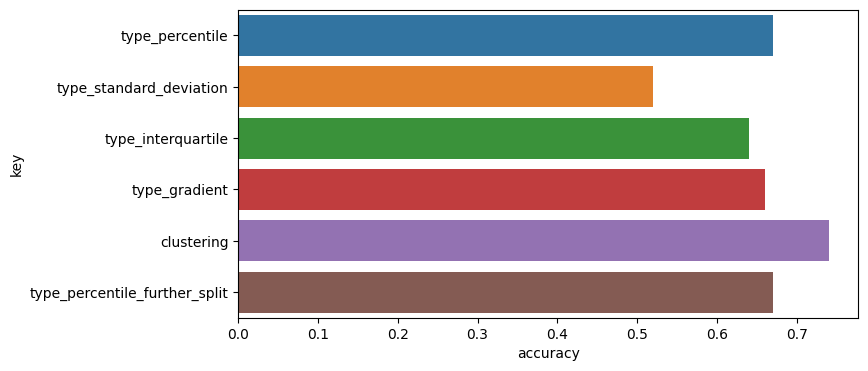

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(y='key', x='accuracy', data=metrics_df)